1. сделаем topic modelling по выставкам. берем столбец с описанием выставки-> токенизируем и лемматизируем -> чистим от стоп-слов -> получаем топик моделинг -> визуализируем

In [ ]:
import spacy
import pandas as pd
from nltk.corpus import stopwords
from nltk import download
import gensim
from tqdm import tqdm
from wordcloud import WordCloud
import matplotlib.pyplot as plt


In [ ]:
download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
df = pd.read_csv('https://raw.githubusercontent.com/AlexeyMakovskiy/HSE_project/main/exhibitions.csv')
df.info()

собираем текст из ячеек с описанием

In [ ]:
full_texts = []
for text in df['description']:
  full_texts.append(text)

In [ ]:
punctuation = '!\"#$%&\'()*+,-./:;<=>?@[\]^_`{|}~—»«...–'
filter = stopwords.words('english') + list(punctuation)

Функция для предобработки, которая токенизирует, лемматизирует и делает все буквы строчными

In [ ]:
def preprocess(input_text):
    nlp = spacy.load("en_core_web_sm")
    tokenized_text = nlp(input_text)
    lowercase_text = [token.text.lower() for token in tokenized_text]
    ## убираем пунктуацию и стоп-слова:
    output_text = [token for token in lowercase_text if token not in filter]
    clean_text = [word for word in output_text if word.isalpha()]
    return clean_text

In [ ]:
preprocessed_texts = []
for text in tqdm(full_texts):
    if isinstance(text, str):
        preprocessed_text = preprocess(text)
        preprocessed_texts.append(preprocessed_text)
    else:
        continue

100%|██████████| 64/64 [00:57<00:00,  1.11it/s]


Создаем словарь из получившихся токенов

In [ ]:
gensim_dictionary_for_TM = gensim.corpora.Dictionary(preprocessed_texts)
gensim_dictionary_for_TM.filter_extremes(no_above=0.1) # , no_below=20
#gensim_dictionary_for_TM.compactify()
print(gensim_dictionary_for_TM)

Dictionary<85 unique tokens: ['ancient', 'artistic', 'developed', 'independence', 'large']...>


In [ ]:
corpus = [gensim_dictionary_for_TM.doc2bow(text) for text in preprocessed_texts]

раскладываем по "мешкам"

In [ ]:
lda = gensim.models.LdaMulticore(corpus,
                                 num_topics = 3, # число топиков
                                 id2word=gensim_dictionary_for_TM,
                                 passes=10)

In [ ]:
lda.print_topics()

[(0,
  '0.048*"works" + 0.046*"women" + 0.045*"connections" + 0.031*"artistic" + 0.030*"little" + 0.026*"national" + 0.026*"identity" + 0.026*"inspired" + 0.025*"materials" + 0.024*"tour"'),
 (1,
  '0.080*"african" + 0.051*"arts" + 0.038*"social" + 0.035*"like" + 0.033*"brought" + 0.033*"gallery" + 0.032*"members" + 0.027*"offers" + 0.026*"europe" + 0.026*"religious"'),
 (2,
  '0.077*"india" + 0.031*"large" + 0.030*"pacific" + 0.030*"set" + 0.028*"way" + 0.027*"ancient" + 0.027*"museums" + 0.024*"graphic" + 0.022*"day" + 0.021*"cambridge"')]

Визуализироем с помощью вордклауд

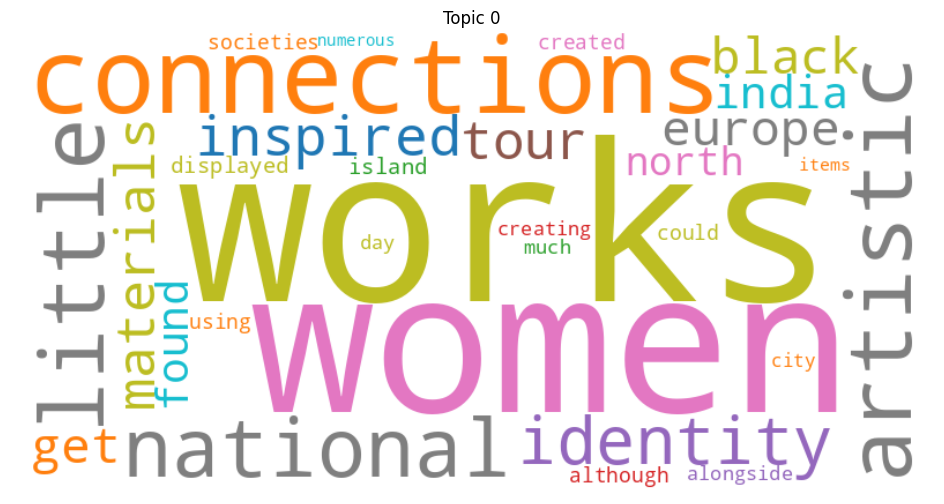

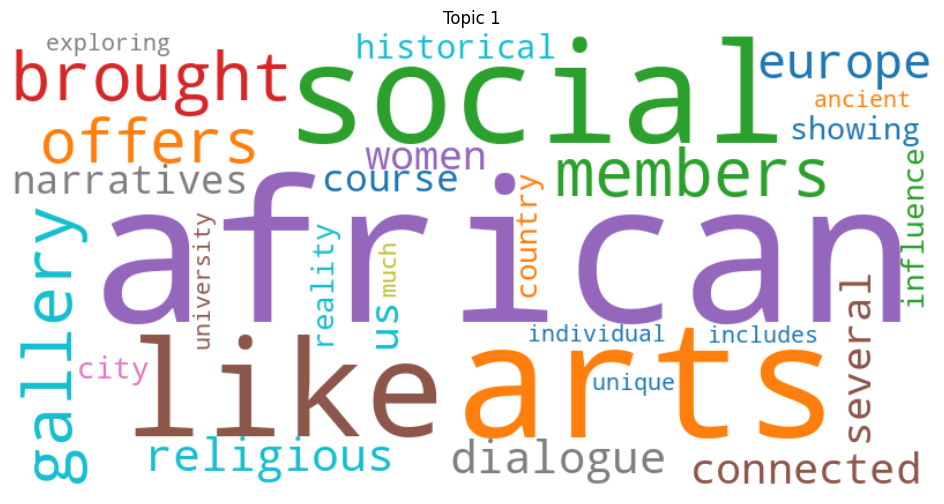

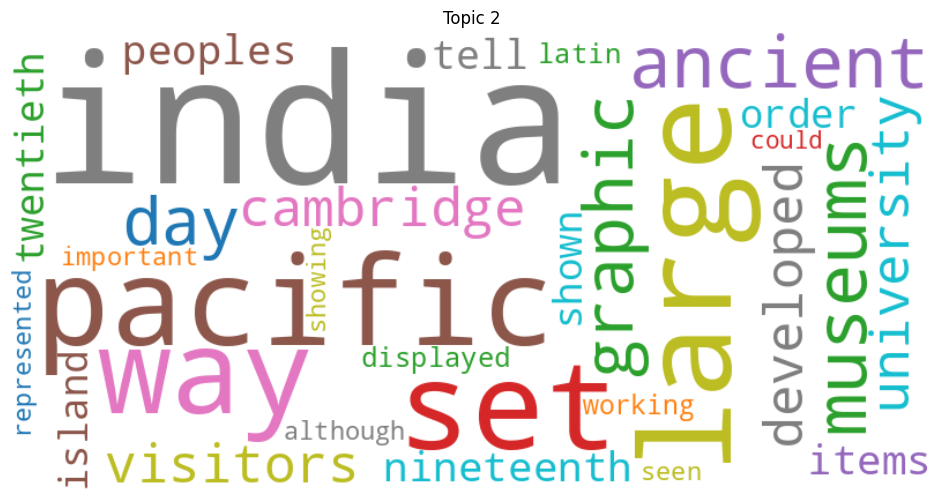

In [ ]:

num_topics = 3

for topic in lda.show_topics(num_topics=num_topics, num_words=30, formatted=False):
    topic_num = topic[0]
    words = dict(topic[1])
    weights = {word: round(weight * 1000) for word, weight in words.items()}

    wordcloud = WordCloud(background_color="white", width=800, height=400, colormap="tab10").generate_from_frequencies(weights)
    plt.figure(figsize=(12,6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title(f"Topic {topic_num}")
    plt.show()